In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn import metrics
from datetime import date
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.simplefilter('ignore')
np.random.seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("./drive/MyDrive/Truist Challenge/train.csv", usecols=range(21))
# sample_submission = pd.read_csv("./drive/MyDrive/Truist Challenge/sample_submission.csv")
# test = pd.read_csv("./drive/MyDrive/Truist Challenge/test.csv")


<table>
<tr><th>Field Name </th> <th> Data Type </th> <th> Description </th></tr>

<tr><td>age</td>
<td>int</td>
<td>client age</td></tr>
<tr><td>generation</td>
<td>string</td>
<td>generation</td></tr>
<tr><td>job</td>
<td>string</td>
<td>client job type</td></tr>
<tr><td>marital</td>
<td>string</td>
<td>client's marital status</td></tr>
<tr><td>education</td>
<td>string</td>
<td>client's education</td></tr>
<tr><td>default</td>
<td>string</td>
<td>client has default in credit</td></tr>
<tr><td>balance</td>
<td>int</td>
<td>average of yearly balance</td></tr>
<tr><td>housing</td>
<td>string</td>
<td>client has housing loan</td></tr>
<tr><td>loan</td>
<td>string</td>
<td>client has personal loan</td></tr>
<tr><td>contact</td>
<td>string</td>
<td>communication type</td></tr>
<tr><td>day</td>
<td>int</td>
<td>most recent contact day of the month</td></tr><tr>
<td>month</td>
<td>string</td>
<td>most recent contact month of the year</td></tr>
<tr><td>duration</td>
<td>int</td>
<td>duration of the most recent contact (in seconds)</td></tr>
<tr><td>campaign</td>
<td>int</td>
<td>number of contacts performed during this campaign for this client</td></tr>
<tr><td>pdays</td>
<td>int</td>
<td>number of days since client was last contacted from previous campaign (-1: client not previously contacted)</td></tr>
<tr><td>previous</td>
<td>int</td>
<td>number of contacts performed before this campaign for this client</td></tr>
<tr><td>poutcome</td>
<td>string</td>
<td>outcome of the previous marketing campaign</td></tr>
<tr><td>state</td>
<td>string</td>
<td>state</td></tr>
<tr><td>zip code</td>
<td>string</td>
<td>zip code</td></tr>
<tr><td>cd</td>
<td>string</td>
<td>client has enrolled in a Certificate of Deposit</td></tr>
</table>

### Read in the data and explore the shape and first 5 rows

In [ ]:
print(data.shape)
data.head()

(36871, 21)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,cd,generation,state,zipcode
0,8054,25,admin.,single,tertiary,no,11924,no,no,unknown,13,jan,4102,32.0,144,8.0,failure,1,Millennials,MT,59776
1,5886,23,housemaid,divorced,primary,no,398,yes,no,cellular,20,jun,66,4.0,15,4.0,unknown,1,Millennials,OH,45438
2,3542,74,unknown,married,unknown,no,2177,yes,no,unknown,19,may,10,3.0,465,4.0,failure,0,Silent Generation,PR,776
3,32553,60,housemaid,married,tertiary,no,26673,yes,no,cellular,6,oct,3902,17.0,396,6.0,unknown,1,Older Boomers,WI,54537
4,11020,32,entrepreneur,single,primary,no,6358,no,yes,unknown,15,feb,3563,28.0,314,24.0,failure,0,Millennials,MP,96952


### DATA DESCRIPTION

In [ ]:
def describe_data(dt):
    cols = list(dt.columns)
    unique = [len(dt[col].unique()) for col in cols]
    is_categorical = ['Yes' if i < 15 else 'No' for i in unique]
    ct = pd.DataFrame(data=cols, columns=['column_name'])
    dt2 = pd.DataFrame(dt.dtypes, columns=['Data Types'])
    dtypes = dt2['Data Types'].astype(str).to_list()
    ct['data_type'] = dtypes
    ct['unique_count'] = unique
    ct['null_count']     = [dt[col].isnull().sum() for col in dt.columns]
    ct['unique'] = [tuple(dt[col].unique()) if len(dt[col].unique()) < 15 else None for col in dt.columns]
    return ct
ct = describe_data(data)
ct

,column_name,data_type,unique_count,null_count,unique
0,id,int64,36871,0,None
1,age,int64,78,0,None
2,job,object,23,52,None
3,marital,object,4,426,"(single, divorced, married, nan)"
4,education,object,6,0,"(tertiary, primary, unknown, secondary, primer..."
5,default,object,2,0,"(no, yes)"
6,balance,int64,26533,0,None
7,housing,object,2,0,"(no, yes)"
8,loan,object,2,0,"(no, yes)"
9,contact,object,3,0,"(unknown, cellular, telephone)"


A few highlights for preprocessing
- cd : is the predicted column
- id : is an identifier column, shouldn't be used for the model
- marital : nan columns can be imputed to a string 'other'
- day, month : should be explored further, we do not understand which year
- In general we explore each column in more detail
    - Predicted column : check for possible imbalance
    - categorical columns : check for misspellings, text case
    - numerical columns : distribution, nulls, correlation

#### Looking at the predicted column

0    28228
1     8643
Name: cd, dtype: int64
Positive class: 23.441186840606438%
Negative class: 76.55881315939357%
Ratio: 0.30618534788153606


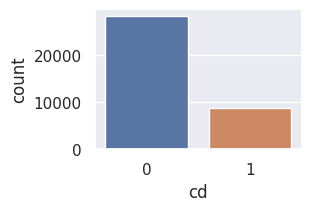

In [ ]:
print(data.cd.value_counts())
positive_class = data[data['cd'] == 1]['cd'].count()
negative_class = data[data['cd'] == 0]['cd'].count()
print(f"Positive class: {positive_class*100/len(data)}%")
print(f"Negative class: {negative_class*100/len(data)}%")
print(f"Ratio: {positive_class/negative_class}")
fig, axes = plt.subplots(figsize = (3,2), constrained_layout = True)
sns.countplot(data=data, x= 'cd')
plt.show()

In [ ]:
data.drop('id', axis=1, inplace=True)
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'cd', 'generation', 'state', 'zipcode'], dtype='object')

## Categorical Columns

In [ ]:
def clean_nan(val):
    """
    Method to replace
    nan with other in
    categorical columns
    and return lower case
    of other strings
    """
    if str(val) == str(np.nan):
        return 'other'
    return val.lower().strip()

def plot_count(col, df=data):
    """
    Function to plot a
    count plot in a
    categorical column
    """
    sns.countplot(data=df, x=col, hue='cd')
    plt.xticks(rotation=90)
    plt.show()

For job
-   Some jobs were repeated with a difference case.
-   Everything is made lower case
-   Categories reduced from 23 to 13

Before: 
['admin.' 'housemaid' 'unknown' 'entrepreneur' 'technician'
 'self-employed' 'student' 'unemployed' 'services' 'management' 'retired'
 'blue-collar' nan 'MANAGEMENT' 'STUDENT' 'ENTREPRENEUR' 'HOUSEMAID'
 'RETIRED' 'UNEMPLOYED' 'TECHNICIAN' 'ADMIN.' 'BLUE-COLLAR'
 'SELF-EMPLOYED']

After: 
['admin.' 'housemaid' 'unknown' 'entrepreneur' 'technician'
 'self-employed' 'student' 'unemployed' 'services' 'management' 'retired'
 'blue-collar' 'other']


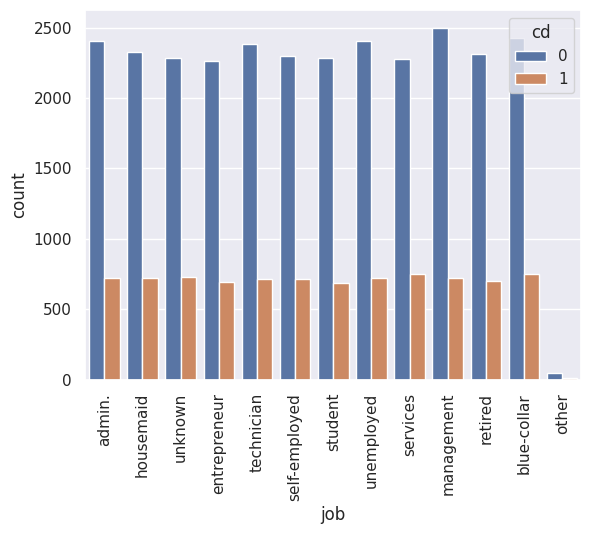

In [ ]:
# job
print(f"Before: \n{data.job.unique()}\n")
data['job'] = data['job'].apply(clean_nan)
print(f"After: \n{data.job.unique()}")
plot_count('job')

BEFORE: 
['single' 'divorced' 'married' nan]

AFTER: 
['single' 'divorced' 'married' 'other']



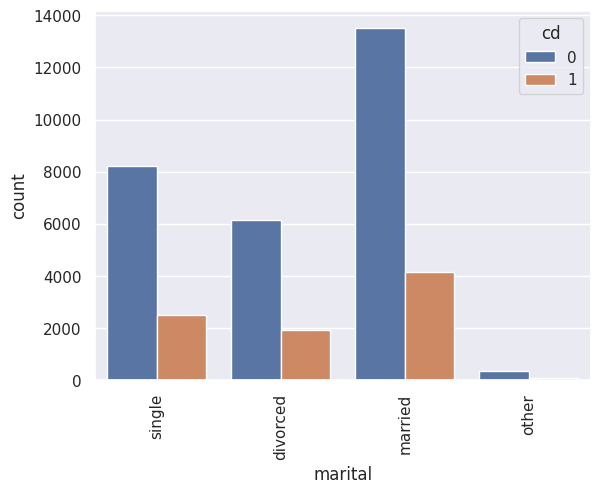

In [ ]:
# marital
print(f"BEFORE: \n{data.marital.unique()}\n")
data['marital'] = data['marital'].apply(clean_nan)
print(f"AFTER: \n{data.marital.unique()}\n")
plot_count('marital')

For Education:
-   Every category was turned to lower case
-   Some categories were mispelled, this was corrected.

BEFORE: 
['tertiary' 'primary' 'unknown' 'secondary' 'primery' 'secendary']

AFTER: 
['tertiary' 'primary' 'unknown' 'secondary']



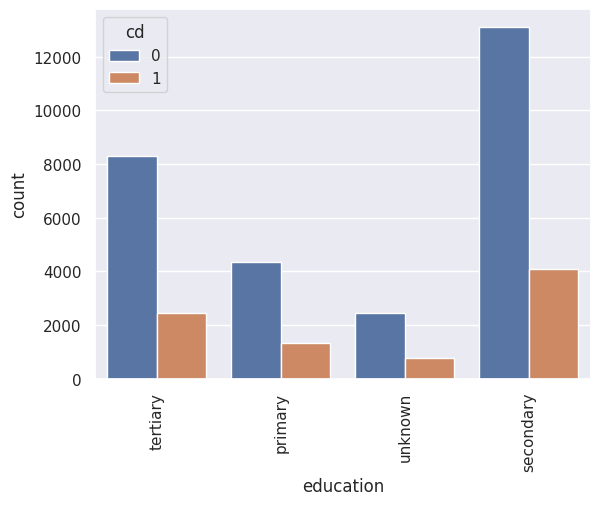

In [ ]:
# education
print(f"BEFORE: \n{data.education.unique()}\n")
def clean_education(val):
    if val == 'secendary':
        return 'secondary'
    elif val == 'primery':
        return 'primary'
    return val.lower().strip()

data['education'] = data['education'].apply(clean_education)
print(f"AFTER: \n{data.education.unique()}\n")
plot_count('education')

BEFORE: 
['no' 'yes']

AFTER: 
[1 0]



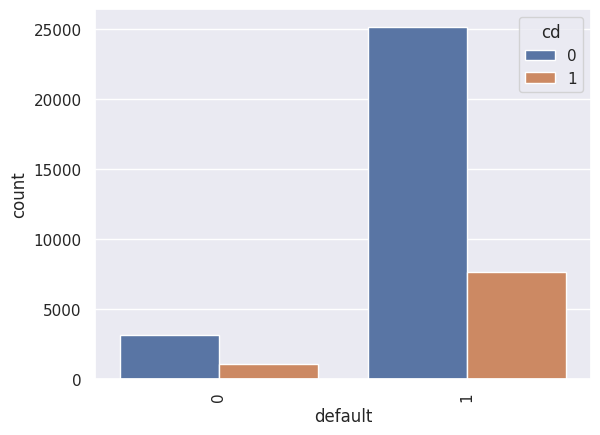

In [ ]:
# default
print(f"BEFORE: \n{data.default.unique()}\n")
data['default'] = data['default'].map({'no':1, 'yes':0})
print(f"AFTER: \n{data.default.unique()}\n")
plot_count('default')


BEFORE: 
['no' 'yes']

AFTER: 
[0 1]



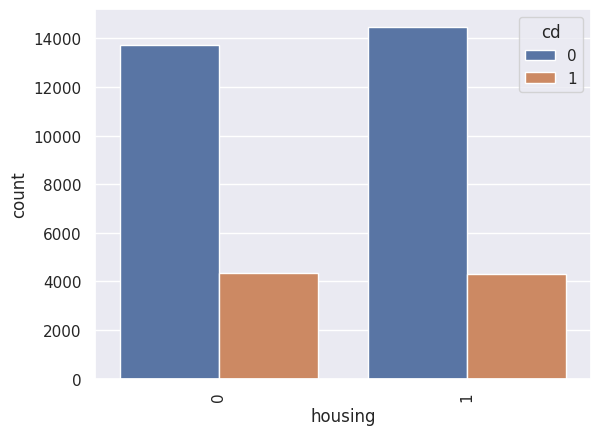

In [ ]:
# housing
print(f"BEFORE: \n{data.housing.unique()}\n")
data['housing'] = data['housing'].map({'no':0, 'yes':1})
print(f"AFTER: \n{data.housing.unique()}\n")
plot_count('housing')

BEFORE: 
['no' 'yes']

AFER: 
[0 1]



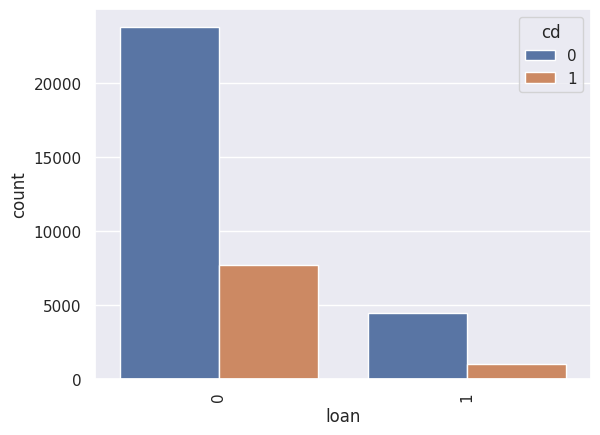

In [ ]:
# loan
print(f"BEFORE: \n{data.loan.unique()}\n")
data['loan'] = data['loan'].map({'no':0, 'yes':1})
print(f"AFER: \n{data.loan.unique()}\n")
plot_count('loan')

BEFORE: 
['unknown' 'cellular' 'telephone']



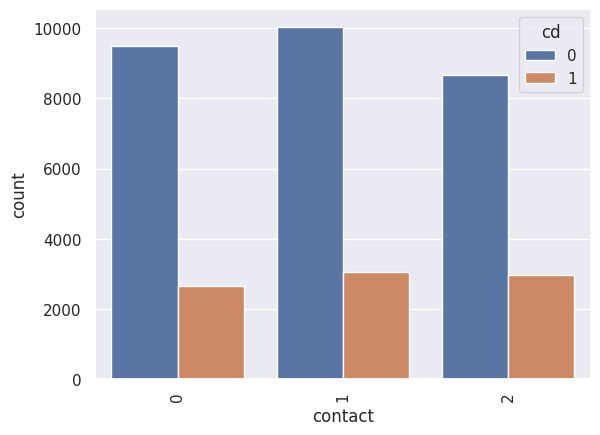

In [ ]:
# contact
print(f"BEFORE: \n{data.contact.unique()}\n")
data['contact'] = data['contact'].map({'unknown':0, 'cellular':1, 'telephone':2})
plot_count('contact')

BEFORE: 
['failure' 'unknown' 'other' 'success']



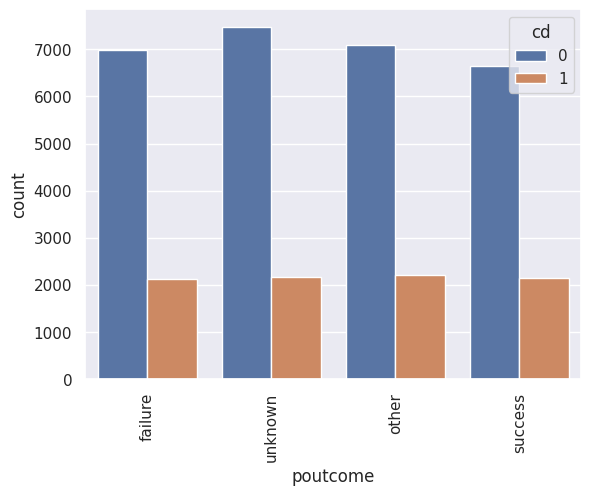

In [ ]:
# poutcome
print(f"BEFORE: \n{data.poutcome.unique()}\n")
plot_count('poutcome')

For state, we got some external data regarding the states with truist branch as we believe people staying in states with Truist are more likely to sign up.

BEFORE: 
['MT' 'OH' 'PR' 'WI' 'MP' 'UT' 'WV' 'LA' 'DE' 'NH' 'MO' 'IN' 'NC' 'KY'
 'AZ' 'DC' 'IA' 'WA' 'MN' 'AL' 'MI' 'PA' 'VT' 'FM' 'NV' 'NE' 'CA' 'AS'
 'GU' 'CO' 'SC' 'MD' 'HI' 'OR' 'NJ' 'NY' 'OK' 'TX' 'VA' 'VI' 'FL' 'IL'
 'TN' 'SD' 'ND' 'MS' 'AK' 'AR' 'CT' 'PW' 'KS' 'NM' 'RI' 'ID' 'MH' 'ME'
 'GA' 'WY' 'MA']



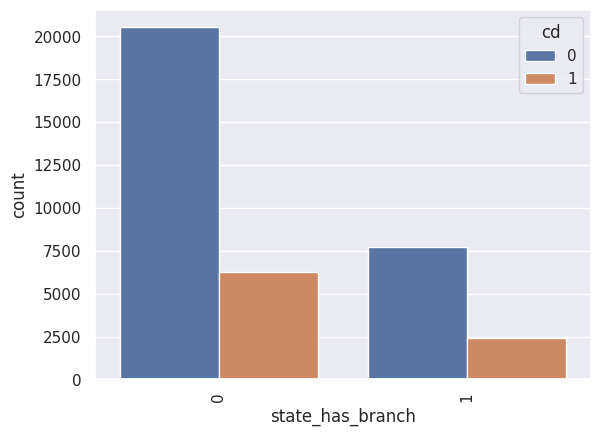

In [ ]:
# zip code and state
print(f"BEFORE: \n{data.state.unique()}\n")
# we will only use state, create a column called state_has_branch with 1 for yes, and 0 for no
# states with truist branches
# states_with_truist = ['Alabama','Florida','Georgia','Indiana','Kentucky','Maryland',
#                       'North Carolina','New Jersey','Ohio','Pennsylvania','South Carolina',
#                       'Tennessee','Texas','Virginia', 'Washington, D.C', 'West Virginia']
states_with_truist = ['AL','FL','GA','IN','KY', 'MD', 'NC', 'NJ', 'OH', 'PA', 'SC', 'TN', 'TX', 'VA', 'WA', 'WV']
data['state_has_branch'] = [1 if i in states_with_truist else 0 for i in data['state']]
data= data.drop(['zipcode','state'], axis=1)
# data= data.drop(['state'], axis=1)
plot_count('state_has_branch')

In [ ]:
# day and month
len(data[(data['day']==30) & (data['month'].isin(['feb']))]) + len(data[(data['day']==31) & (data['month'].isin(['feb', 'apr','jun','sep', 'nov']))])

249

For day and month,
-   we are not sure which year is being referred to.
-   We also realised there 249 rows where the dates are non-existant like 30-feb, 31-feb, 31-apr, 31-sep
-   Based on these facts, we decided to drop these columns

In [ ]:
data = data.drop(['day','month'], axis=1)

### Numerical columns

- We looked at the distributions
- We also looked at transformed distributions
    - log
    - sqrt
    - cube root
    - squared
    - cubic

In [ ]:
sns.set()
def plot_distributions(col, dt = data):
    fig, axes = plt.subplots(2,3,figsize = (10,4), constrained_layout = True)
    axes = axes.ravel()
    sns.histplot(data = dt, x=dt[col], hue=dt['cd'],ax=axes[0])
    axes[0].set_title('Normal Data')
    sns.histplot(data = dt, x=np.log(dt[col]+1e-7),hue=dt['cd'], ax=axes[1])
    axes[1].set_title('Log Data')
    sns.histplot(data = dt, x=dt[col]**(1/2), hue=dt['cd'],ax=axes[2])
    axes[2].set_title('Sqrt Data')
    sns.histplot(data = dt, x=dt[col]**(1/3), hue=dt['cd'],ax=axes[3])
    axes[3].set_title('Cbrt Data')
    sns.histplot(data = dt, x=dt[col]**(2), hue=dt['cd'],ax=axes[4])
    axes[4].set_title('Sqare Data')
    sns.histplot(data = dt, x=dt[col]**(3), hue=dt['cd'],ax=axes[5])
    axes[5].set_title('Cubic Data')
    fig.suptitle(col)
    plt.show()

In [ ]:
# # numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'year_days_to_recent_contact']
# numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
# for col in numerical_cols:
#     plot_distributions(col)
#     print()

A few take aways
-   No column has normally distributed data
-   Some columns have skewed distributions (long tail)
-   The transformations do not neccesarily make the data better
-   sqrt and cbrt of pdays tend more to normal distribution than normal data
-   Generally transforming the data may not have a much effect on the data

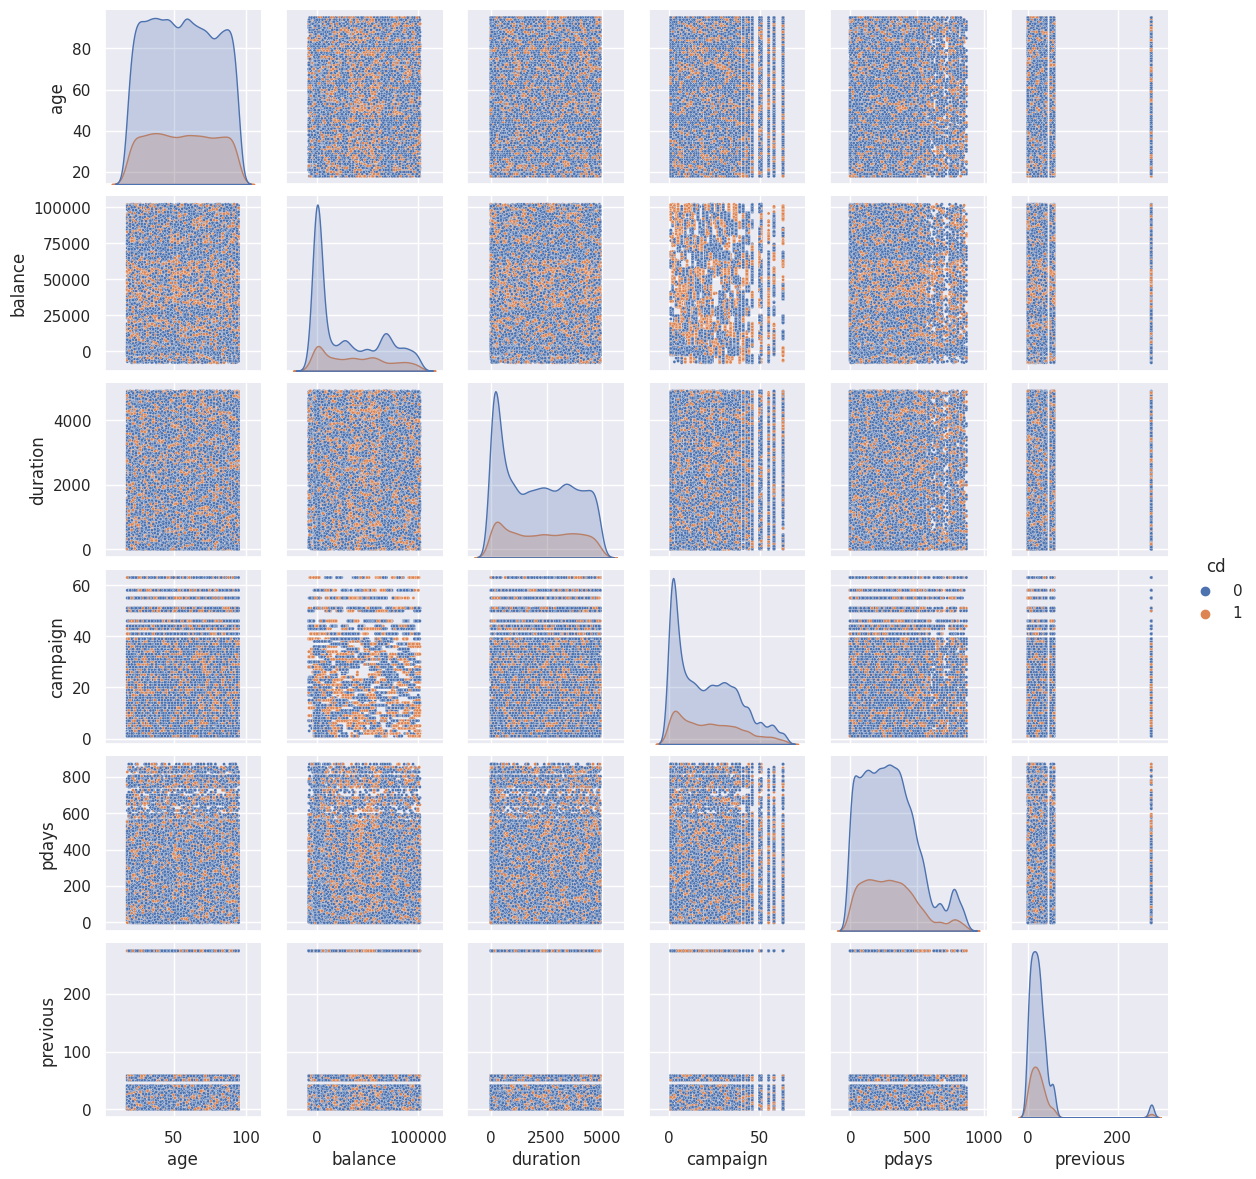

In [ ]:
pairplot_data = data[numerical_cols]
pairplot_data['cd'] = data['cd']
sns.set(font_scale=1)
sns.pairplot(pairplot_data, hue='cd', height=2, plot_kws={"s": 5}, diag_kind='kde')

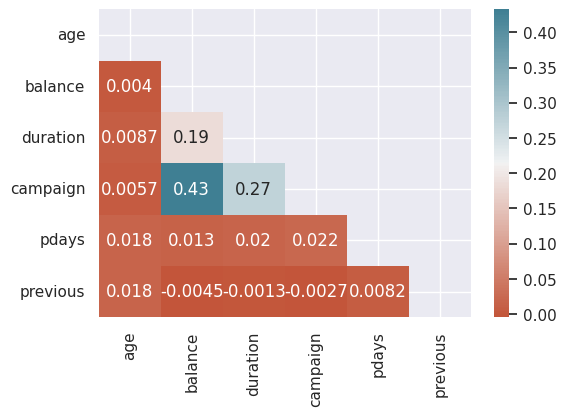

In [ ]:
correlation = data[numerical_cols].corr()
# ploting the correlation heatmap
fig, ax = plt.subplots(figsize=(6,4))
matrix = np.triu(correlation)
ax=sns.heatmap(correlation, cmap=sns.diverging_palette(20, 220, n=200), mask = matrix, annot=True)

In [ ]:
describe_data(data[numerical_cols])

,column_name,data_type,unique_count,null_count,unique
0,age,int64,78,0,None
1,balance,int64,26533,0,None
2,duration,int64,4907,0,None
3,campaign,float64,49,9,None
4,pdays,int64,559,0,None
5,previous,float64,42,377,None


dealing with the null values

In [ ]:
# dealing with nulls
data.dropna(inplace=True)

In [ ]:
describe_data(data[numerical_cols])

,column_name,data_type,unique_count,null_count,unique
0,age,int64,78,0,None
1,balance,int64,26159,0,None
2,duration,int64,4903,0,None
3,campaign,float64,48,0,None
4,pdays,int64,559,0,None
5,previous,float64,41,0,None


In [ ]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,cd,generation,state_has_branch
0,25,admin.,single,tertiary,1,11924,0,0,0,4102,32.0,144,8.0,failure,1,Millennials,0
1,23,housemaid,divorced,primary,1,398,1,0,1,66,4.0,15,4.0,unknown,1,Millennials,1
2,74,unknown,married,unknown,1,2177,1,0,0,10,3.0,465,4.0,failure,0,Silent Generation,0
3,60,housemaid,married,tertiary,1,26673,1,0,1,3902,17.0,396,6.0,unknown,1,Older Boomers,0
4,32,entrepreneur,single,primary,1,6358,0,1,0,3563,28.0,314,24.0,failure,0,Millennials,0


Next we transform the non numeric categorical columns

In [ ]:
other_categorical_columns = ['job', 'marital', 'education', 'poutcome', 'generation']
new_data = pd.get_dummies(data, columns=other_categorical_columns, drop_first=True)
print(new_data.shape)

(36214, 43)


In [ ]:
new_data.shape

(36214, 43)

In [ ]:
X = new_data.drop('cd', axis=1)
y = new_data['cd']

After we define the X and y, we split the data into train and test sets.

The goal here is to test simple models and know which estimator might work best for the model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.7, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}\nTest shape: {X_test.shape}")

ValueError: ignored

In [ ]:
def prediction_statistics(y_actual, y_predicted):
    """
    Method prints classification matrix
    and given accuracy measures
    and plots a confusion matrix

    """
    print(metrics.classification_report(y_actual, y_predicted))
    auc = metrics.roc_auc_score(y_actual, y_predicted) * 100
    print(f"AUC: {round(auc,3)}%")
    cm=metrics.confusion_matrix(y_actual, y_predicted)
    classes = list(set(y_predicted))
    print(f"***** Confusion Matrix *****")
    sns.set(font_scale=0.8)
    fig, ax = plt.subplots(figsize=(2,2))
    ax = sns.heatmap(cm,
                cmap=sns.diverging_palette(20, 220, n=200),
                annot=True,
                fmt='g')
    ax.set_yticklabels(classes, rotation=90)
    ax.set_xticklabels(classes)

In [ ]:
def compute_auc_for_model(estimator, x, y):
    xtrain,xtest,ytrain,ytest = train_test_split(x,y, train_size=.7, random_state=42, stratify=y)
    est = estimator.fit(xtrain,ytrain)
    pred = est.predict(xtest)
    print(f"AUC: {metrics.roc_auc_score(ytest,pred)}")
    return est

### Logistic regression

In [ ]:
lr = LogisticRegression(random_state=42)
lr = compute_auc_for_model(lr,X,y)

AUC: 0.5003915426781519


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt = compute_auc_for_model(dt,X,y)

AUC: 0.7361872967556182


### Knn Classifier

In [ ]:
knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn = compute_auc_for_model(knn,X,y)

AUC: 0.5105851497204363


### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf = compute_auc_for_model(rf,X,y)

AUC: 0.5214194715290383


10-fold cross validation:

ROC AUC: 0.51 (+/- 0.01) [Logistic regression]
ROC AUC: 0.75 (+/- 0.01) [Decision tree]
ROC AUC: 0.53 (+/- 0.00) [kNN]
ROC AUC: 0.70 (+/- 0.01) [Random Forest]


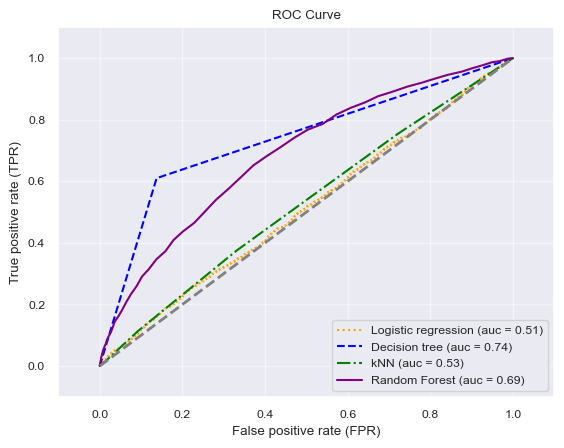

In [ ]:


# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'kNN', 'Random Forest']
estimators = [lr, dt, knn, rf]

#################################### Cross - Validation ####################################


print('5-fold cross validation:\n')
for clf, label in zip(estimators, clf_labels): #For all classifiers
    scores = cross_val_score(estimator=clf,  # estimate AUC based on cross validation
                             X=X,
                             y=y,
                             cv=5,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" # print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green', 'purple']      # colors for visualization
linestyles = [':', '--', '-.', '-', ]        # line styles for visualization
for clf, label, clr, ls in zip(estimators,
               clf_labels, colors, linestyles):

    # Assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # make predictions based on the classifiers

    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test,       # build ROC curve
                                     y_score=y_pred)
    roc_auc = metrics.auc(x=fpr, y=tpr)                           # compute Area Under the Curve (AUC)
    plt.plot(fpr, tpr,                                    # plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')    # where to place the legend
plt.plot([0, 1], [0, 1],         # visualize random classifier
         linestyle='--',         # aesthetic parameters
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.title("ROC Curve")
plt.show()


We see that Decision Tree performs best on the simple model.

Therefore out of the basic models we shall proceed with it.

### FEATURE ENGINEERING
-   For numerical features
-   We shall perform log, sqrt, cbrt transformations

In [ ]:
# features
X_sqrt = X.copy()
X_cbrt = X.copy()
X_log = X.copy()

def polynomial_transform(col, transformation):
    return transformation(col)

for col in  numerical_cols:
    X_sqrt[f'{col}_sqrt'] = polynomial_transform(X[col], np.sqrt)
    X_cbrt[f'{col}_cbrt'] = polynomial_transform(X[col], np.cbrt)
    X_log[f'{col}_log'] = polynomial_transform(np.add(X[col],1e-6), np.log)

print(f"Orig: {X.shape}, Sqrt: {X_cbrt.shape}, Cbrt: {X_sqrt.shape}, Cbrt: {X_log.shape}\n")

Orig: (36214, 43), Sqrt: (36214, 49), Cbrt: (36214, 49), Cbrt: (36214, 49)



In [ ]:
compute_auc_for_model(DecisionTreeClassifier(random_state=42),X_sqrt,y)

AUC: 0.6985088164707415


In [ ]:
compute_auc_for_model(DecisionTreeClassifier(random_state=42),X_cbrt,y)

AUC: 0.7357814557736737


In [ ]:
compute_auc_for_model(DecisionTreeClassifier(random_state=42),X_log,y)

AUC: 0.6983732063637674


In [ ]:
compute_auc_for_model(DecisionTreeClassifier(random_state=42),X,y)

AUC: 0.7361872967556182


As earlier suggested, transforming the data may not have alot of effect on the model.

The best set is still the normal X set

Chosen columns: 35


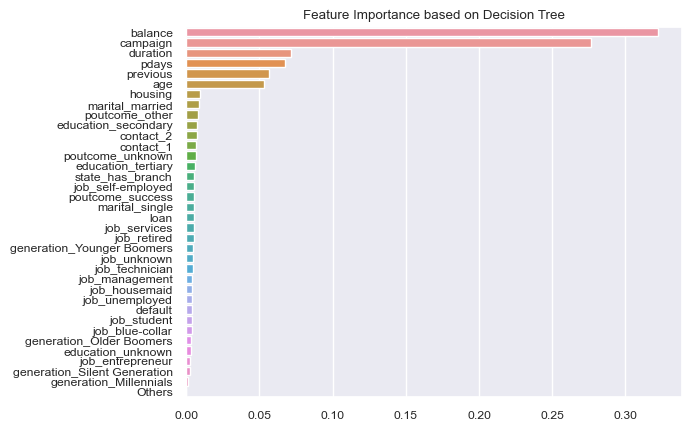

In [ ]:
# Getting feature importance
# Using Decision Tree
def get_feature_importance(x, y):
    decision = DecisionTreeClassifier(criterion='entropy', random_state=42,)
    decision.fit(x, y)

    # put importance and X columns in a dictionary
    importance = list(decision.feature_importances_)
    X_cols = list(x.columns)
    importance = dict(zip(X_cols,importance))
    # remove columns with no importance and sort in descending order
    importance = {v:k for (k,v) in importance.items() if v > 0.001}
    importance = {importance.get(k):k for k in sorted(importance,reverse=True)}
    return importance
imp = get_feature_importance(X, y)
chosen_cols = list(imp.keys())
print(f"Chosen columns: {len(chosen_cols)}")
imp['Others']=0

sns.barplot(y=list(imp.keys()), x = list(imp.values()))
plt.title("Feature Importance based on Decision Tree")
plt.show()

In [ ]:
print(chosen_cols)

['balance', 'campaign', 'duration', 'pdays', 'previous', 'age', 'housing', 'marital_married', 'poutcome_other', 'education_secondary', 'contact_2', 'contact_1', 'poutcome_unknown', 'education_tertiary', 'state_has_branch', 'job_self-employed', 'poutcome_success', 'marital_single', 'loan', 'job_services', 'job_retired', 'generation_Younger Boomers', 'job_unknown', 'job_technician', 'job_management', 'job_housemaid', 'job_unemployed', 'default', 'job_student', 'job_blue-collar', 'generation_Older Boomers', 'education_unknown', 'job_entrepreneur', 'generation_Silent Generation', 'generation_Millennials']


In [ ]:
dt = DecisionTreeClassifier(random_state=42)
compute_auc_for_model(dt,X[chosen_cols],y)


AUC: 0.7371824304327453


In [ ]:
def fit_grid_searchCV(model, params, x, y):
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    gs_cv = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring='roc_auc', # Specifying multiple metrics for evaluation
                    cv=inner_cv,
                    n_jobs=-1)
    gs_cv = gs_cv.fit(x,y)
    print(f"Non-nested CV AUC Measure:  {gs_cv.best_score_}")
    # Mean cross-validated score of the best_estimator
    print(f"Optimal Parameter:  {gs_cv.best_params_}")
    #Parameter setting that gave the best results on the hold out data.
    print(f"Optimal Estimator:  {gs_cv.best_estimator_}\n")
    # Estimator that was chosen by the search, i.e. estimator which
    # gave highest score (or smallest loss if specified) on the left out data
    nested_score_gs = cross_val_score(estimator=gs_cv, X=x, y=y, cv=outer_cv, scoring='roc_auc', n_jobs=-1)
    print(f"Nested CV AUC Measure: {nested_score_gs.mean()},  (+/-) {nested_score_gs.std()}")
    return gs_cv

In [ ]:
dt_params = { "max_depth": [None,  11, 23, 35, 47, 55,63 ],
              "criterion": ['entropy', 'gini'],
              "min_samples_split": [2, 3, 5, 10, 14, 20],
              "min_samples_leaf":[1, 5, 6, 8, 23 ]  }

dt = DecisionTreeClassifier(random_state=42)
best_dt = fit_grid_searchCV(dt, dt_params, X[chosen_cols], y)

Non-nested CV AUC Measure:  0.8551790973377761
Optimal Parameter:  {'criterion': 'entropy', 'max_depth': 23, 'min_samples_leaf': 23, 'min_samples_split': 2}
Optimal Estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=23, min_samples_leaf=23,
                       random_state=42)

Nested CV AUC Measure: 0.8537413402023842,  (+/-) 0.011163926950980516


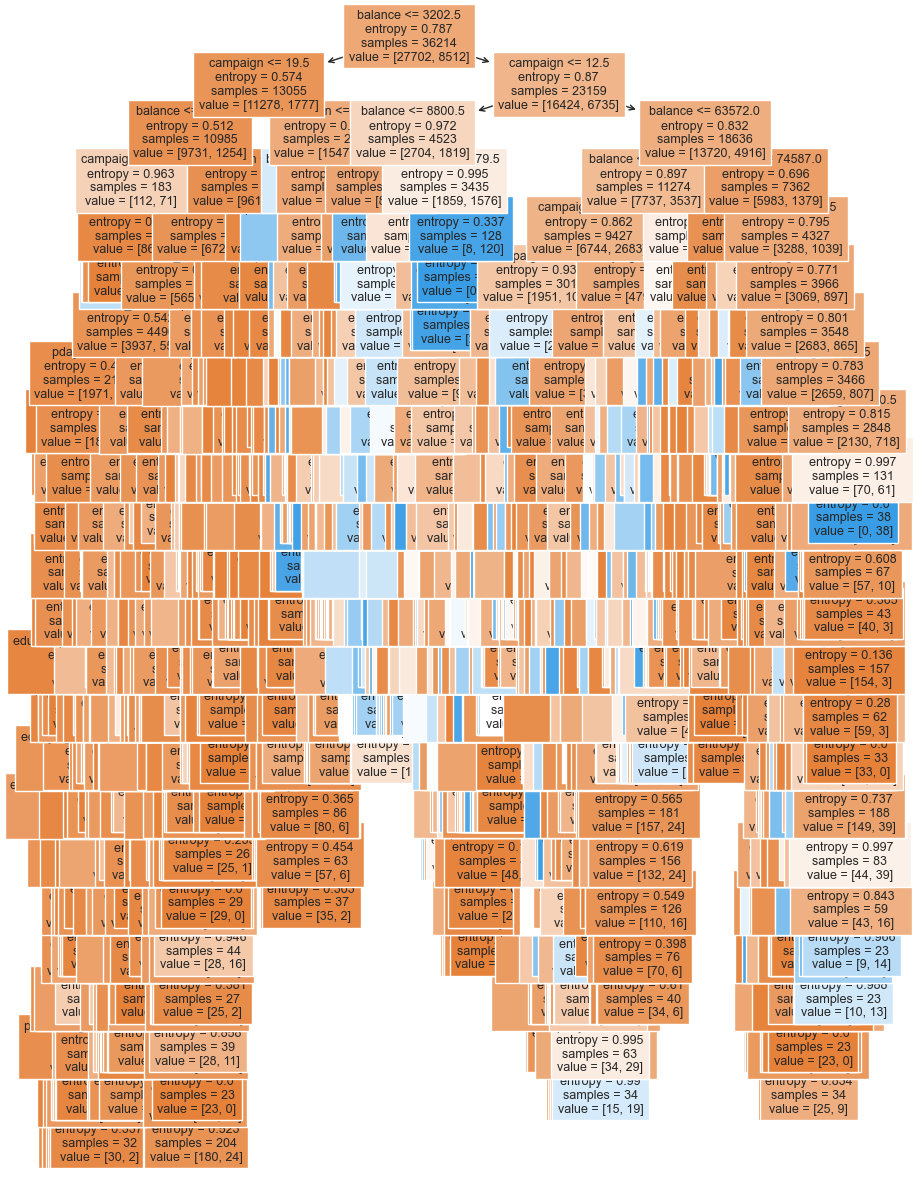

In [ ]:
fig, ax = plt.subplots(figsize=(10, 15))
plot_tree(best_dt.best_estimator_.set_params(max_depth = 3),
          fontsize=9,
          filled=True,
          feature_names = chosen_cols,
        #   class_names = ['Churn-Yes', 'Churn-No']
          )
plt.show()

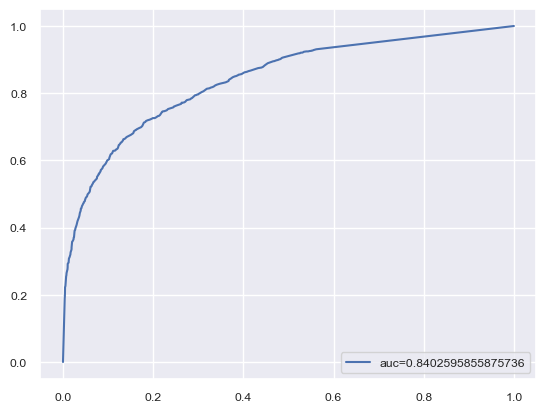

In [ ]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y, train_size=.7, random_state=42, stratify=y)
dt = best_dt.best_estimator_
best_dt.fit(Xtrain,ytrain)
y_pred_proba = best_dt.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
